# Further Data Analysis

We're going to conduct a bit more Data Analysis and in this process also conduct a simple mean imputation as a baseline model for our data.

First of all we import our data.

In [2]:
library(lubridate)
library(dlookr)
library(dplyr)
library(mice)
library(VIM)
library(Amelia)
library(Zelig)


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Loading required package: mice


Attaching package: 'mice'


The following object is masked from 'package:stats':

    filter


The following objects are masked from 'package:base':

    cbind, rbind


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'dlookr'


The following object is masked from 'package:base':

    transform



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: colorspace

Loading required package: grid

VIM is ready to use.


Suggestions and bug-reports can be submitted at: https://github.com/statistikat/VIM/issues


Attaching package: 'VIM'


The following object is masked from 'package:datasets':

 

In [3]:
temp2 <- tempfile()
start <- proc.time()
download.file("https://github.com/Galeforse/DST-Assessment-02/raw/main/Data/1_percent_data.csv.gz",temp2)
data <- (read.csv(gzfile(temp2)))
print("Data imported in:")
print(seconds_to_period((proc.time()-start)[3]))

[1] "Data imported in:"
[1] "2.57000000000002S"


In [4]:
temp2 <- tempfile()
start <- proc.time()
download.file("https://github.com/Galeforse/DST-Assessment-02/raw/main/Data/1_percent_data_head.csv.gz",temp2)
datah <- (read.csv(gzfile(temp2)))
print("Data imported in:")
print(seconds_to_period((proc.time()-start)[3]))

[1] "Data imported in:"
[1] "2.00999999999999S"


In [7]:
head(data)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,http,0.03,481,8133,RSTO,0,ShADadfR,8,813,9,8505
2,1331923392,192.168.202.110,11574,192.168.23.253,1724,tcp,,NA,NA,NA,REJ,0,Sr,1,48,1,40
3,1331905217,192.168.202.83,41267,192.168.206.44,8010,tcp,,NA,NA,NA,REJ,0,Sr,1,60,1,40
4,1331994375,192.168.202.83,58519,192.168.206.44,5214,tcp,,NA,NA,NA,REJ,0,Sr,1,60,1,40
5,1331999507,192.168.202.140,25774,192.168.23.252,1625,tcp,,NA,NA,NA,S0,0,S,1,48,0,0
6,1331935766,192.168.202.83,60760,192.168.206.44,1580,tcp,,NA,NA,NA,REJ,0,Sr,1,60,1,40


In [9]:
mtab0=data.frame(
    missingduration=is.na(data[,"duration"]),
    proto=data[,"proto"])
mtab=table(mtab0)
(apply(mtab,2,function(x)x/sum(x)))

,icmp,tcp,udp
FALSE,0.8683921,0.1649403,0.3135747
TRUE,0.1316079,0.8350597,0.6864253


In [10]:
mtab0=data.frame(
    missingduration=is.na(datah[,"duration"]),
    proto=datah[,"proto"])
mtab=table(mtab0)
(apply(mtab,2,function(x)x/sum(x)))

,icmp,tcp,udp
FALSE,0.2989691,0.6409311,0.2180095
TRUE,0.7010309,0.3590689,0.7819905


The above code is taken from the workshop on missing data and is used to see the randomness of the missing `duration` (which will therefore also apply to `orig_bytes` and `resp_bytes`). It seems that the data is not missing completely at random as there seems to be trends between what protocol corresponds to missing data. However it is interesting to note that oddly enough, for the two datasets we're looking at, the `tcp` and `icmp` protocol seem to flip in trend between the two, which suggests this trend may not be prevalent throughout the whole data set, but it could also be bias from our sample.

(As an extra note in the workshop the above command was used on the complete dataset and showed a trend similar to the random sample `data` set so it seems that most of the data would follow this trend and our "head" data is skewed in that regard.)

Now, we're going to have a look for some outliers.

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"98 y values <= 0 omitted from logarithmic plot"


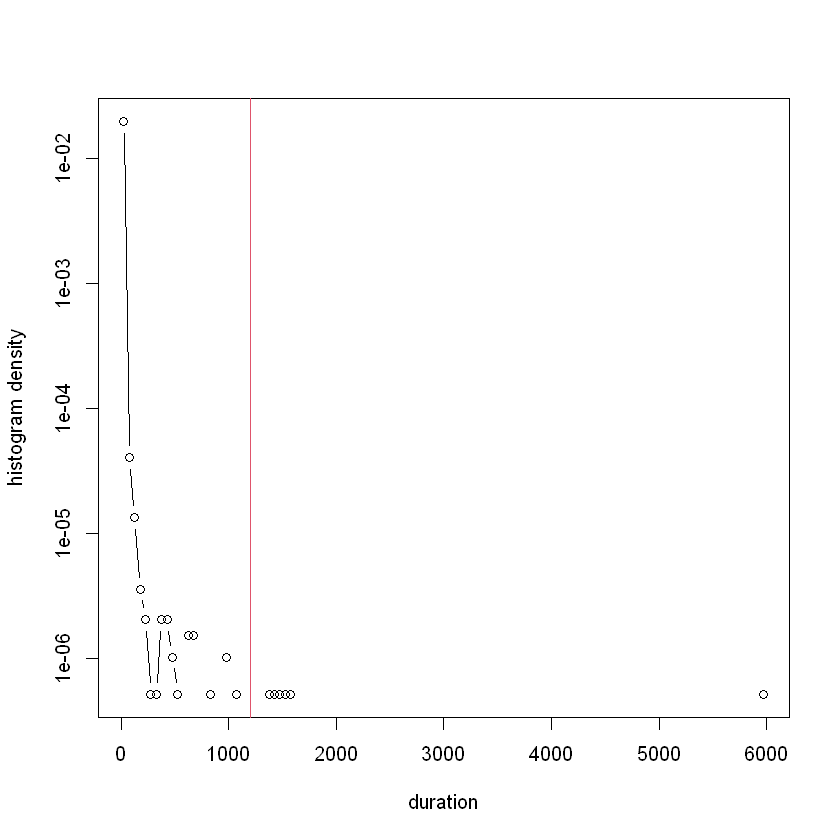

In [11]:
nbreaks=101 
thist=hist(data[,"duration"],breaks=nbreaks,plot=FALSE)

plot(thist$mids,thist$density,log="y",type="b",
     xlab="duration",ylab="histogram density")
threshold=1200 
abline(v=threshold,col=2) 

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"44 y values <= 0 omitted from logarithmic plot"


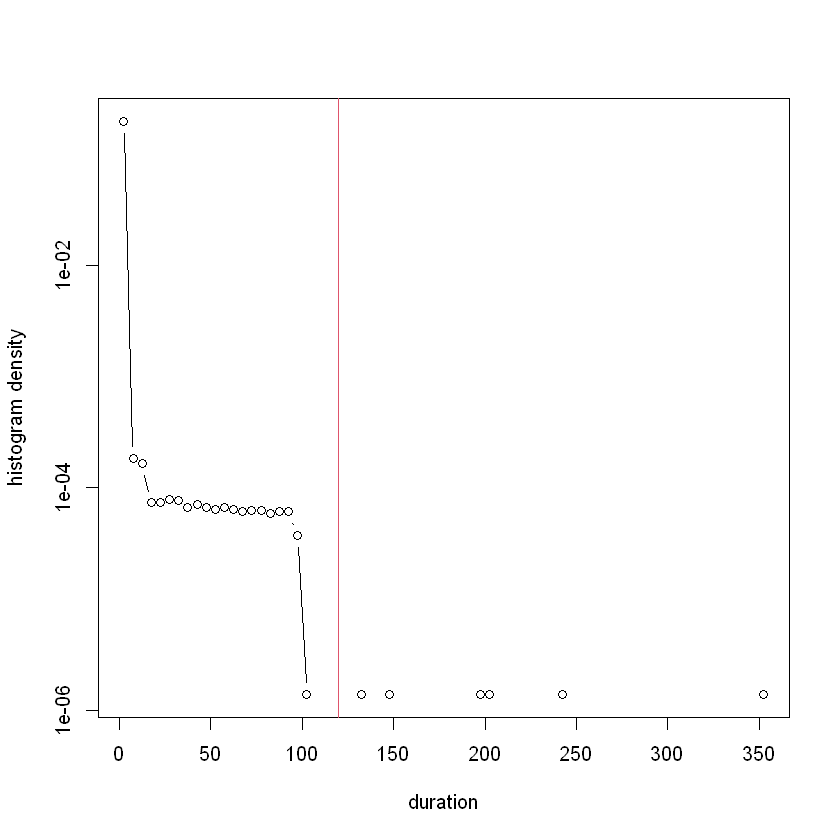

In [14]:
nbreaks=101 
thist=hist(datah[,"duration"],breaks=nbreaks,plot=FALSE)

plot(thist$mids,thist$density,log="y",type="b",
     xlab="duration",ylab="histogram density")
threshold=120
abline(v=threshold,col=2) 

We see that the outliers in the "head" data are considerably more spaced out than in the randomly sampled but there seems to a similar amount in each dataset. The most noteable thing we can see in these graphs is that the duration variable in the sampled data is considerable less than in the randomly sampled, possibly showing a time bias on the data (i.e. the head data is early on in the data and might not reflect the general distribution of the data).

We can verify whether each point is an outlier with different statistical tests. We first want use Grubbs test but this relys on our data being approximately normally distrubted. But our data contains missing values so we use mean imputation to impute some data. 

We will also drop the service column due to the reasons previously stated.

In [18]:
data1 <- subset(data, select = -c(service))
datah1 <- subset(datah, select = -c(service))

We are also going to add a `logduration` column as for some methods the `duration` variable ends up being regressed wrongly resulting in a negative value which we do not want to see!

In [22]:
data1[,"logduration"]=log(data1[,"duration"])
datah1[,"logduration"]=log(datah1[,"duration"])

In [24]:
conn_mean<-data1
conn_mean[is.na(conn_mean[,"duration"]),
              "duration"]=
    mean(na.omit(conn_mean[,"duration"]))
conn_mean[is.na(conn_mean[,"orig_bytes"]),
              "orig_bytes"]=
    mean(na.omit(conn_mean[,"orig_bytes"]))
conn_mean[is.na(conn_mean[,"resp_bytes"]),
              "resp_bytes"]=
    mean(na.omit(conn_mean[,"resp_bytes"]))
conn_mean[is.na(conn_mean[,"logduration"]),
              "logduration"]=
    mean(na.omit(conn_mean[,"logduration"]))
head(conn_mean)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,logduration
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>
1,1331915797,192.168.202.102,2633,192.168.23.202,80,tcp,0.030000,481.0,8133.0000,RSTO,0,ShADadfR,8,813,9,8505,-3.506558
2,1331923392,192.168.202.110,11574,192.168.23.253,1724,tcp,1.474315,518931.4,666.5486,REJ,0,Sr,1,48,1,40,-3.160371
3,1331905217,192.168.202.83,41267,192.168.206.44,8010,tcp,1.474315,518931.4,666.5486,REJ,0,Sr,1,60,1,40,-3.160371
4,1331994375,192.168.202.83,58519,192.168.206.44,5214,tcp,1.474315,518931.4,666.5486,REJ,0,Sr,1,60,1,40,-3.160371
5,1331999507,192.168.202.140,25774,192.168.23.252,1625,tcp,1.474315,518931.4,666.5486,S0,0,S,1,48,0,0,-3.160371
6,1331935766,192.168.202.83,60760,192.168.206.44,1580,tcp,1.474315,518931.4,666.5486,REJ,0,Sr,1,60,1,40,-3.160371


In [25]:
conn_meanh<-datah1
conn_meanh[is.na(conn_meanh[,"duration"]),
              "duration"]=
    mean(na.omit(conn_meanh[,"duration"]))
conn_meanh[is.na(conn_meanh[,"orig_bytes"]),
              "orig_bytes"]=
    mean(na.omit(conn_meanh[,"orig_bytes"]))
conn_meanh[is.na(conn_meanh[,"resp_bytes"]),
              "resp_bytes"]=
    mean(na.omit(conn_meanh[,"resp_bytes"]))
conn_meanh[is.na(conn_meanh[,"logduration"]),
              "logduration"]=
    mean(na.omit(conn_meanh[,"logduration"]))
head(conn_meanh)

,ts,orig_ip,orig_port,resp_ip,resp_port,proto,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,logduration
,<dbl>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>
1,1331901000,192.168.202.79,50463,192.168.229.251,80,tcp,0.3745079,50.35395,21.58427,SH,0,Fa,1,52,1,52,-3.664367
2,1331901000,192.168.202.79,46117,192.168.229.254,443,tcp,0.3745079,50.35395,21.58427,SF,0,dDafFr,3,382,9,994,-3.664367
3,1331901000,192.168.202.79,50465,192.168.229.251,80,tcp,0.0100000,166.00000,214.00000,SF,0,ShADfFa,4,382,3,382,-4.605170
4,1331901000,192.168.202.79,50467,192.168.229.251,80,tcp,0.0100000,166.00000,214.00000,SF,0,ShADfFa,4,382,3,382,-4.605170
5,1331901000,192.168.202.79,46119,192.168.229.254,443,tcp,0.0200000,544.00000,1060.00000,SF,0,ShADadfFr,8,968,13,1744,-3.912023
6,1331901000,192.168.202.79,46121,192.168.229.254,443,tcp,0.0100000,544.00000,1060.00000,SF,0,ShADadfFr,8,968,13,1744,-4.605170


In [ ]:
plot(density(conn_mean[,"logduration"]))

In [ ]:
plot(density(conn_mean[,"orig_bytes"]))